<a href="https://colab.research.google.com/github/adrianmarino/neural-network-from-scratch/blob/master/Neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Neural Network From Scratch

In [0]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_circles

## Utilities used to plot and inpect (Do not Read, Go forward :) )

In this session only exist utils and helper classes for inspect network structure.**This code is not important to interstand  hwo works a Neural network.** 

In [0]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

In [0]:
class NetworkPlotter:
    def __init__(self, network): self.network = network

    def __layers_size(self):
        layers = []
        for index,layer in enumerate(self.network.layers):
            layers.append(layer.inputs)
            if index == len(self.network.layers) - 1:
               layers.append(layer.neurons)
        return layers

    def __topology(self):
        return pd.DataFrame(
             [(l.name(), l.inputs,l.neurons, l.activation.name()) for l in self.network.layers],
            columns=['Layer', 'Inputs', 'Neurons', 'Activation']
        )

    def plot(self):
        fig = plt.figure(figsize=(11, 11))
        ax = fig.gca()
        ax.axis('off')
        draw_neural_net(ax, .1, .9, .1, .9, self.__layers_size())
        fig.savefig('nn.png')
        return self.__topology()


In [0]:
class DatasetPlotter:
    def __init__(self, dataset): self.dataset = dataset

    def plot(self):
        plt.scatter(
            self.dataset.features[self.dataset.labels == 0, 0], 
            self.dataset.features[self.dataset.labels == 0, 1],
            c='skyblue'
        )
        plt.scatter(
            self.dataset.features[self.dataset.labels == 1, 0], 
            self.dataset.features[self.dataset.labels == 1, 1],
            c='salmon'
        )
        plt.axis('equal')
        plt.grid()
        plt.show()

In [0]:
class FunctionPlotter:
    def __init__(self, function): self.function = function

    def plot(self, x_values):
        plt.title(f'{self.function.name()} Function')
        plt.grid()
        plt.plot(x_values, [self.function.compute(x) for x in x_values])
        plt.show()

In [0]:
def normal_rand_tensor(*dimensions):
    """Allow create a tensor with specified dimensions 
    and random values bethween -1 and 1.
    
    Examples: 
        - normal_rand_tensor(2): Create a two elements array. 
        - normal_rand_tensor(2, 2): Create (2, 2) matrix.
        - normal_rand_tensor(2, 2, 2): Create (2, 2, 3) tensor.
        - etc...
    """
    return np.random.rand(*dimensions) * 2 -1

## Create dataset (Begin to read from this point ;))

In [0]:
class CirclesDataset:
    def __init__(self, samples_count, factor, noise, shuffle=True):
        self.features, self.labels = make_circles(
            n_samples=samples_count, 
            shuffle=True,
            factor=factor,
            noise=noise
        )
    def plot(self): DatasetPlotter(self).plot()

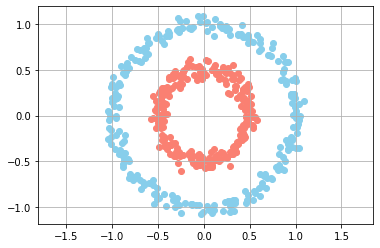

In [8]:
dataset = CirclesDataset(
    samples_count=500, 
    factor=0.5, 
    noise=0.05, 
    shuffle=True
)
dataset.plot()

## Activation functions

In [0]:
from abc import ABCMeta, abstractmethod

class Function(metaclass=ABCMeta):
    @abstractmethod
    def compute(self, x): pass

    @abstractmethod
    def compulte_derivate(self, x): pass
    
    def name(self): return self.__class__.__name__

    def plot(self, x_values): FunctionPlotter(self).plot(x_values)

class Sigmoide(Function):
    def compute(self, x): return 1 / (1 + np.e ** (-x))
    def compulte_derivate(self, x): return x * (1 -x)

class RELU(Function):
    def compute(self, x): return np.maximum(0, x)
    def compulte_derivate(self, x): return 1 if x == 1 else 0

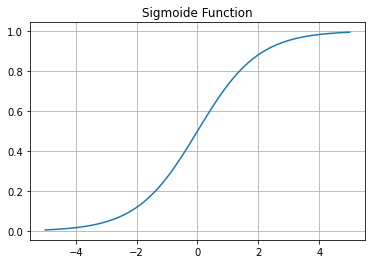

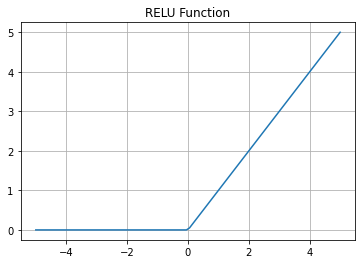

In [10]:
Sigmoide().plot(x_values=np.linspace(-5, 5, 100))
RELU().plot(x_values=np.linspace(-5, 5, 100))

## Neural network

In [0]:
class LayerOutput:
    def __init__(self, weighted_sum, activation):
       self.weighted_sum = weighted_sum
       self.activation = activation

class DenseLayer:
    def __init__(self, inputs, neurons, activation):
        self.inputs = inputs
        self.neurons = neurons
        self.activation = activation
        self.biases = normal_rand_tensor(1, neurons)
        self.W = normal_rand_tensor(inputs, neurons)

    def name(self):
        return 'Dense'
    
    def compute(self, inputs):
        z = inputs @ self.W + self.biases
        a = self.activation.compute(z)
        return LayerOutput(weighted_sum=z, activation=a)

In [0]:
class NetworkBuilder:
    def __init__(self): self.__layers = []
    
    def build(self): return Network(self.__layers)

    def resolve_inputs(self, default_inputs): 
        return self.__layers[-1].neurons if len(self.__layers) > 0 else default_inputs

    def dense(self, activation, neurons, inputs=-1):
        inputs = self.resolve_inputs(inputs)
        layer = DenseLayer(inputs, neurons, activation)
        self.__layers.append(layer)
        return self
    
    def sigm_dense(self, neurons, inputs=-1): 
        self.dense(Sigmoide(), neurons, inputs)
        return self

    def relu_dense(self, neurons, inputs=-1): 
        self.dense(RELU(), neurons, inputs)
        return self

In [0]:
class TrainResume:
    def __init__(self, outputs, loss):
        self.loss = loss  
        self.outputs = outputs

In [0]:
class Network:
    @staticmethod
    def builder(): return NetworkBuilder()

    def __init__(self, layers): self.layers = layers

    def plot(self): return NetworkPlotter(self).plot()

    def __forward_pass(self, X):
        outputs = [LayerOutput(None, X)]
        for layer in self.layers:
            last_output = outputs[-1]
            outputs.append(layer.compute(inputs=last_output.activation))
        return outputs
    
    def train(self, X, Y, loss, lr):
        outputs = self.__forward_pass(X)
        loss_value = loss.compute(outputs[-1].activation, Y)
        return TrainResume(outputs, loss_value)

## Loss functions

In [0]:
class MeanSquareError(Function):
    def compute(self, Yp, Yr): return np.mean((Yp - Yr) ** 2)
    def compulte_derivate(self, Yp, Yr): return Yp - Yr

### Build neural network

In [0]:
network = Network \
    .builder() \
    .sigm_dense(neurons = 4, inputs = 2) \
    .sigm_dense(neurons = 8) \
    .sigm_dense(neurons = 16) \
    .sigm_dense(neurons = 8) \
    .sigm_dense(neurons = 4) \
    .sigm_dense(neurons = 1) \
    .build()

,Layer,Inputs,Neurons,Activation
0,Dense,2,4,Sigmoide
1,Dense,4,8,Sigmoide
2,Dense,8,16,Sigmoide
3,Dense,16,8,Sigmoide
4,Dense,8,4,Sigmoide
5,Dense,4,1,Sigmoide


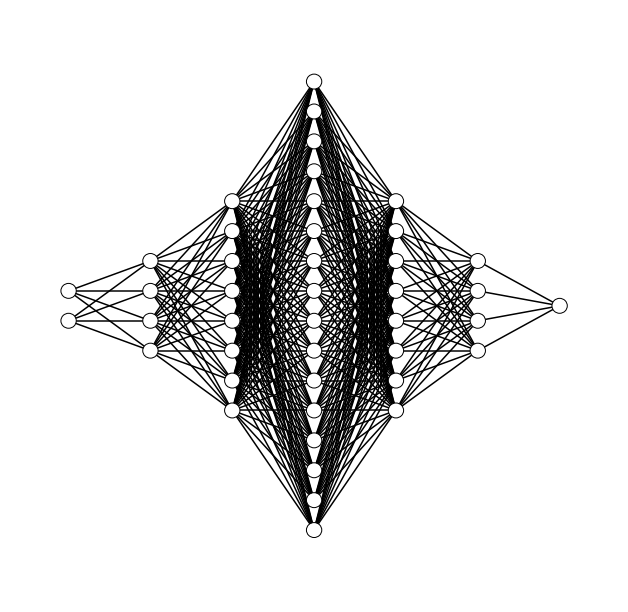

In [17]:
network.plot()

## Train Network

In [18]:
summary = network.train(
    dataset.features,
    dataset.labels,
    loss=MeanSquareError(),
    lr=0.5
)
summary.loss

0.2653904331848136